**NOTE**: According to documentation the grid is 0.5 x 0.5 degrees

In [1]:
import xarray as xr
# import rioxarray as rio
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, MultiPolygon
import shapely.wkt



In [2]:
# # importando api earth engine
# import ee/home/mapbiomasar/Mayra/OCO2_L4/OCO2_L4/OCO2GriddedXCO2_20180709_v2_1605313492.nc
# # autorização com login 
# ee.Authenticate()
# # iniciando a biblioteca
# ee.Initialize()

In [7]:
file_name = '/home/mapbiomasar/Mayra/OCO2_L4/OCO2_L4/OCO2GriddedXCO2_20180709_v2_1605313492.nc'
nc_file = xr.open_dataset(file_name)
nc_file

/home/mapbiomasar/miniconda3/envs/geoproc/lib/python3.9/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


<xarray.Dataset>
Dimensions:                 (time: 4268, levels: 20, epoch_dimension: 7)
Coordinates:
  * time                    (time) datetime64[ns] 2018-07-09T22:37:01.4404933...
  * levels                  (levels) int16 1 2 3 4 5 6 7 ... 15 16 17 18 19 20
Dimensions without coordinates: epoch_dimension
Data variables: (12/14)
    latitude                (time) float32 ...
    longitude               (time) float32 ...
    xco2                    (time) float32 ...
    xco2_apriori            (time) float32 ...
    xco2_uncertainty        (time) float32 ...
    pressure_levels         (time, levels) float32 ...
    ...                      ...
    pressure_weight         (time, levels) float32 ...
    source_data_mode        (time) float32 ...
    date                    (time, epoch_dimension) float32 ...
    decorrelation_distance  (time) float64 ...
    land_inflation_factor   float64 ...
    ocean_inflation_factor  float64 ...
Attributes: (12/15)
    title:                          OCO-2 Gridded Level 4 bias-corrected XCO2...
    VersionID:                      2
    OCO2DataVersion:                v10
    ShortName:                      OCO2GriddedXCO2
    RangeBeginningDate:             2018-07-09
    RangeBeginningTime:             00:39:51.307112
    ...                             ...
    IdentifierProductDOI:           10.5067/7KURDO0SQE1R
    IdentifierProductDOIAuthority:  http://dx.doi.org/
    GranuleID:                      OCO2GriddedXCO2_20180709_v2_1605313492.nc
    Format:                         netCDF
    ProcessingLevel:                4
    Conventions:                    CF-1.7

In [8]:
xco2 = nc_file[[
    'longitude',
    'latitude',
    'xco2'
]]
xco2 = xco2.to_dataframe()

crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(xco2['longitude'], xco2['latitude'])]

points = gpd.GeoDataFrame(xco2, 
                          crs = crs, 
                          geometry = geometry)


/home/mapbiomasar/miniconda3/envs/geoproc/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [5]:
points

,longitude,latitude,xco2,geometry
time,,,,
2018-07-09 22:37:01.440493312,-166.5,68.5,407.806946,POINT (-166.50000 68.50000)
2018-07-09 22:37:01.447142144,-165.5,68.5,407.798340,POINT (-165.50000 68.50000)
2018-07-09 22:37:01.456375296,-164.5,68.5,407.784454,POINT (-164.50000 68.50000)
2018-07-09 22:37:01.460187904,-163.5,68.5,407.778473,POINT (-163.50000 68.50000)
2018-07-09 22:37:01.395579136,-163.5,69.5,407.778076,POINT (-163.50000 69.50000)
...,...,...,...,...
2018-07-09 01:00:59.330523392,179.5,36.5,406.851410,POINT (179.50000 36.50000)
2018-07-09 01:01:10.213266176,179.5,37.5,406.677460,POINT (179.50000 37.50000)
2018-07-09 01:01:20.163509504,179.5,38.5,406.669250,POINT (179.50000 38.50000)


In [5]:
buffers = points.buffer(0.5)
bounds = buffers.bounds

bounds['pixel_area'] = bounds.apply(
  lambda obj: Polygon(shell=[
    Point(obj['maxx'],obj['miny']),
    Point(obj['minx'],obj['miny']),
    Point(obj['minx'],obj['maxy']),
    Point(obj['maxx'],obj['maxy']),
    Point(obj['maxx'],obj['miny']),
  ]),
  axis=1
)



merge = bounds.merge(points, on='time')
merge

/tmp/ipykernel_124214/3502002941.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffers = points.buffer(0.5)


,minx,miny,maxx,maxy,pixel_area,longitude,latitude,xco2,geometry
time,,,,,,,,,
2020-07-01 19:49:36.537283840,-126.0,72.0,-125.0,73.0,"POLYGON ((-125 72, -126 72, -126 73, -125 73, ...",-125.5,72.5,408.380310,POINT (-125.50000 72.50000)
2020-07-01 19:49:36.287692544,-125.0,72.0,-124.0,73.0,"POLYGON ((-124 72, -125 72, -125 73, -124 73, ...",-124.5,72.5,408.396545,POINT (-124.50000 72.50000)
2020-07-01 19:49:43.523562752,-125.0,74.0,-124.0,75.0,"POLYGON ((-124 74, -125 74, -125 75, -124 75, ...",-124.5,74.5,408.786316,POINT (-124.50000 74.50000)
2020-07-01 19:49:35.770023680,-124.0,72.0,-123.0,73.0,"POLYGON ((-123 72, -124 72, -124 73, -123 73, ...",-123.5,72.5,408.410675,POINT (-123.50000 72.50000)
2020-07-01 19:49:35.055913472,-124.0,73.0,-123.0,74.0,"POLYGON ((-123 73, -124 73, -124 74, -123 74, ...",-123.5,73.5,408.207336,POINT (-123.50000 73.50000)
...,...,...,...,...,...,...,...,...,...
2020-07-01 01:25:44.790880256,179.0,17.0,180.0,18.0,"POLYGON ((180 17, 179 17, 179 18, 180 18, 180 ...",179.5,17.5,414.123657,POINT (179.50000 17.50000)
2020-07-01 01:25:56.083312640,179.0,18.0,180.0,19.0,"POLYGON ((180 18, 179 18, 179 19, 180 19, 180 ...",179.5,18.5,414.189117,POINT (179.50000 18.50000)
2020-07-01 01:26:10.618141184,179.0,19.0,180.0,20.0,"POLYGON ((180 19, 179 19, 179 20, 180 20, 180 ...",179.5,19.5,414.282684,POINT (179.50000 19.50000)


/home/mapbiomasar/miniconda3/envs/geoproc/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Text(0.5, 1.0, 'xco2 from GoSat L4')

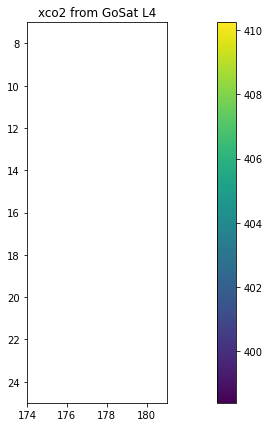

In [7]:

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(18, 7))


ax.set_xlim(174.0, 181.0)
ax.set_ylim(25.0, 7.0)
world.plot(ax=ax, alpha=0.4, color='grey')


gpd.GeoDataFrame(
  merge,
  crs = crs, 
  geometry = [a for a in merge['pixel_area']]                                
  ).plot(column='xco2', ax=ax, legend=True)

plt.title('xco2 from GoSat L4')

/home/mapbiomasar/miniconda3/envs/geoproc/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Text(0.5, 1.0, 'xco2 from GoSat L4')

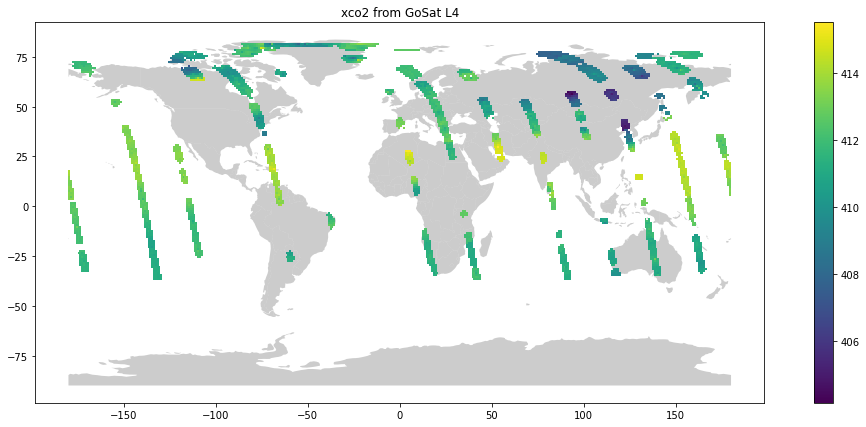

In [6]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(18, 7))


# ax.set_xlim(178.0, 181.0)
# ax.set_ylim(20.0, 23.0)
world.plot(ax=ax, alpha=0.4, color='grey')

gpd.GeoDataFrame(
  merge,
  crs = crs, 
  geometry = [a for a in merge['pixel_area']]                                
  ).plot(column='xco2', ax=ax, legend=True)

# gpd.GeoDataFrame(
#   points,
#   crs = crs, 
#   geometry = [a for a in points['geometry']]                                
#   ).plot(column='xco2', ax=ax)



plt.title('xco2 L4')


In [9]:

gdf = merge.copy()
gdf = gpd.GeoDataFrame(
  gdf,
  crs = crs, 
  geometry = [a for a in gdf['pixel_area']]                               
  )
gdf = gdf.reset_index()
gdf = gdf.loc[:,gdf.columns.isin(['xco2', 'geometry'])]

print('--> TYPE: ',type(gdf))
gdf



--> TYPE:  <class 'geopandas.geodataframe.GeoDataFrame'>


/home/mapbiomasar/miniconda3/envs/geoproc/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,xco2,geometry
0,407.806946,"POLYGON ((-166.00000 68.00000, -167.00000 68.0..."
1,407.798340,"POLYGON ((-165.00000 68.00000, -166.00000 68.0..."
2,407.784454,"POLYGON ((-164.00000 68.00000, -165.00000 68.0..."
3,407.778473,"POLYGON ((-163.00000 68.00000, -164.00000 68.0..."
4,407.778076,"POLYGON ((-163.00000 69.00000, -164.00000 69.0..."
...,...,...
4263,406.851410,"POLYGON ((180.00000 36.00000, 179.00000 36.000..."
4264,406.677460,"POLYGON ((180.00000 37.00000, 179.00000 37.000..."
4265,406.669250,"POLYGON ((180.00000 38.00000, 179.00000 38.000..."
4266,406.661713,"POLYGON ((180.00000 39.00000, 179.00000 39.000..."


In [10]:
print('--> ',type(gdf))
gdf.to_file('/home/mapbiomasar/MJT/notebooks/xco2GridL420180709.shp')


/home/mapbiomasar/miniconda3/envs/geoproc/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-->  <class 'geopandas.geodataframe.GeoDataFrame'>
